## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import random
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from models import *
from utils import *
from train import *
from bvc import *
from gen_data import *

sns.set_theme(style='white', font_scale=1.25)

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
v_idx = 164

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Feedforward BNN

In [3]:
X_train, Y_train = load_data('./data/', 'feedforward_train.pkl')
X_test, Y_test = load_data('./data/', 'feedforward_test.pkl')
X_valid, Y_valid = load_data('./data/', 'feedforward_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [ ]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30,
    **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Best hidden unit: 256, best layers: 4


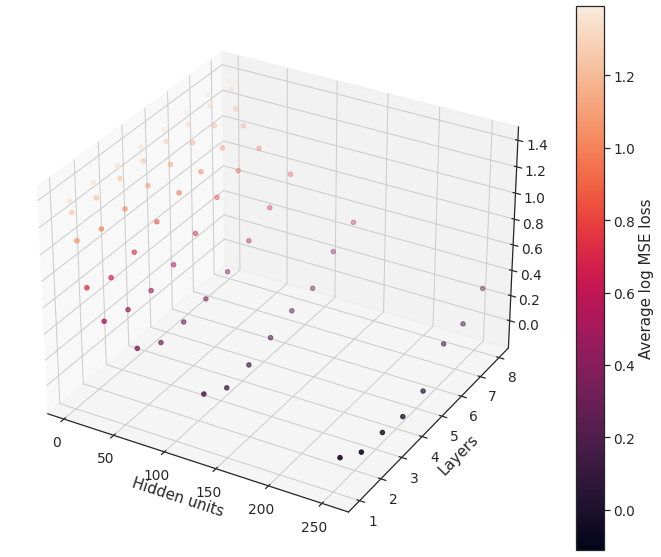

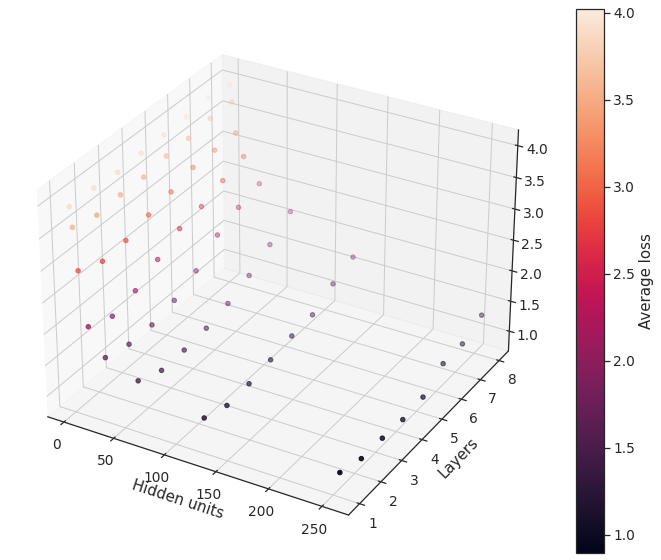

In [6]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]
avg_final_eval_loss = torch.load('./temp/param_search_feedforward.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='feedforward_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='feedforward')
torch.save(avg_final_eval_loss, './temp/param_search_feedforward.pt')

####  2. Learning with best parameter

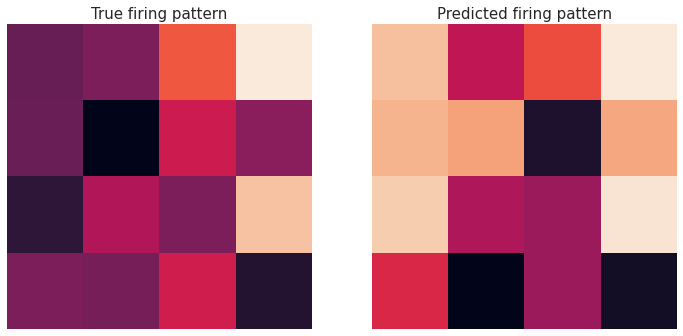

Initial eval loss: 3.751449167728424
Epoch 1: training loss 26.32092460989952, eval loss 1.668293684720993. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 3.5304074808955193, eval loss 0.5969478860497475. Time elapsed: 0 h 0 m 10 s.
Epoch 101: training loss 2.339466691017151, eval loss 0.676951639354229. Time elapsed: 0 h 0 m 21 s.
Epoch 151: training loss 1.4177283644676208, eval loss 0.5407020598649979. Time elapsed: 0 h 0 m 32 s.
Epoch 201: training loss 1.6737525332719088, eval loss 0.6401572301983833. Time elapsed: 0 h 0 m 43 s.
Epoch 251: training loss 2.4006431847810745, eval loss 0.5030001029372215. Time elapsed: 0 h 0 m 54 s.
Epoch 301: training loss 1.646273449063301, eval loss 0.5759669095277786. Time elapsed: 0 h 1 m 6 s.
Epoch 351: training loss 2.426538472995162, eval loss 0.7238235026597977. Time elapsed: 0 h 1 m 16 s.
Epoch 401: training loss 0.7211130056530237, eval loss 0.5020372122526169. Time elapsed: 0 h 1 m 27 s.
Epoch 451: training loss 1.6173243541270494, ev

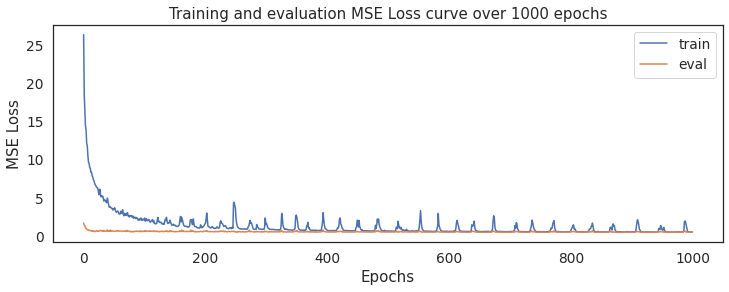

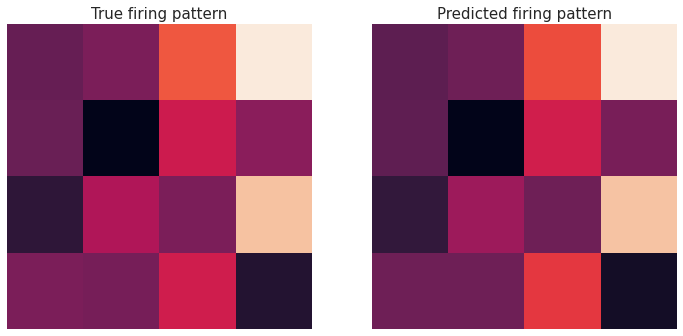

In [4]:
v_idx = 163 # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1, :], DNN(X_test[v_idx,-1, :]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss', fname='ff_mlp')

visualise_prediction(Y_test[v_idx,-1, :], DNN(X_test[v_idx,-1, :])) # visualise after training

#### 3. Testing against predicting the mean

In [5]:
with torch.no_grad(): 
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.0971, device='cuda:0')
Predicting mean MSE error on test set tensor(0.7493, device='cuda:0')


In [3]:
mses_ff = []
n_repeats = 20
for _ in tqdm(range(n_repeats)):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=False, force_stop=False)
    
    mses_ff.append(F.mse_loss(DNN(X_test), Y_test))
    
print(torch.mean(torch.Tensor(mses_ff)))
print(torch.std(torch.Tensor(mses_ff)))

100%|██████████| 20/20 [1:17:55<00:00, 233.76s/it]

tensor(0.0996)
tensor(0.0065)


### Residual BNN

In [5]:
X_train, Y_train = load_data('./data/', 'residual_train.pkl')
X_test, Y_test = load_data('./data/', 'residual_test.pkl')
X_valid, Y_valid = load_data('./data/', 'residual_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [15]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})
torch.save(avg_final_eval_loss, './temp/skip_param_search.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.8790516257286072, time elapsed: 0 h 1 m 5 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.9283478707075119, time elapsed: 0 h 2 m 20 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.8991737216711044, time elapsed: 0 h 3 m 42 s
4th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.8843117356300354, time elapsed: 0 h 5 m 11 s
5th repeat: best hidden unit: 256, best layers: 2, final eval loss: 0.8974523991346359, time elapsed: 0 h 6 m 39 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.8541746437549591, time elapsed: 0 h 8 m 5 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.882461741566658, time elapsed: 0 h 9 m 28 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.9118118435144424, time elapsed: 0 h 10 m 57 s
9th repeat: best hidden unit: 256

Best hidden unit: 256, best layers: 3


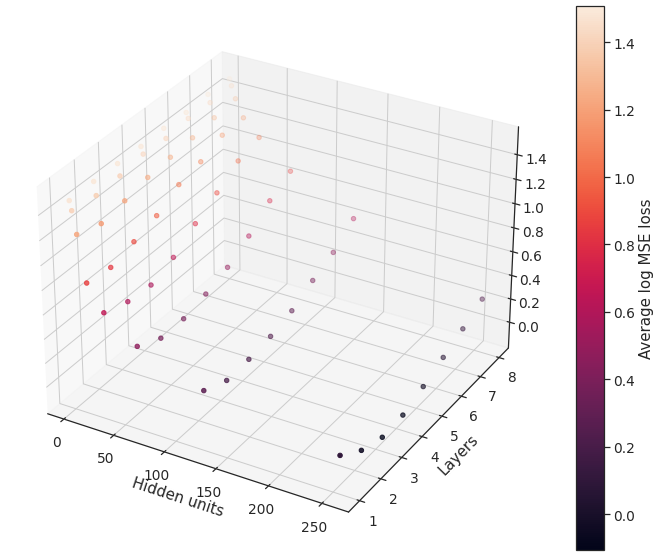

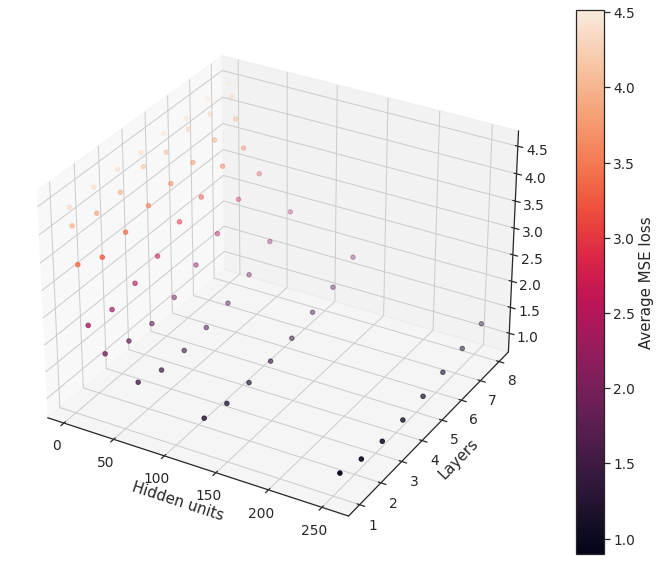

In [16]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]
avg_final_eval_loss = torch.load('./temp/skip_param_search.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='residual_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='residual')


#### 2. Learning with best parameter

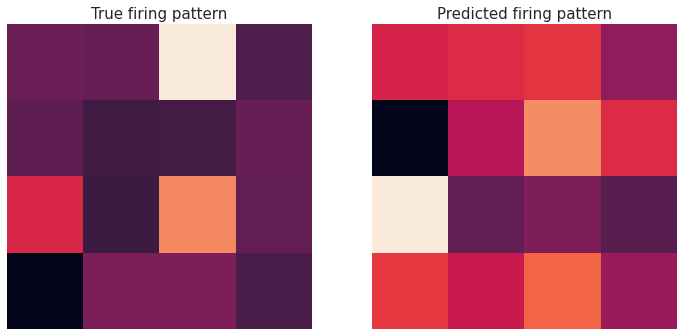

Initial eval loss: 4.279079258441925
Epoch 1: training loss 27.648969262838364, eval loss 1.8808728158473969. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 2.7772410921752453, eval loss 0.5051745623350143. Time elapsed: 0 h 0 m 11 s.
Epoch 101: training loss 1.8965431898832321, eval loss 0.44271206855773926. Time elapsed: 0 h 0 m 23 s.
Epoch 151: training loss 1.2688653878867626, eval loss 0.4254584386944771. Time elapsed: 0 h 0 m 34 s.
Epoch 201: training loss 1.8859182428568602, eval loss 0.4940396323800087. Time elapsed: 0 h 0 m 46 s.
Epoch 251: training loss 1.7997383251786232, eval loss 0.45770054310560226. Time elapsed: 0 h 0 m 57 s.
Epoch 301: training loss 0.8728242218494415, eval loss 0.3889255151152611. Time elapsed: 0 h 1 m 9 s.
Epoch 351: training loss 0.910905372351408, eval loss 0.39766330271959305. Time elapsed: 0 h 1 m 21 s.
Epoch 401: training loss 0.8284233156591654, eval loss 0.38471847027540207. Time elapsed: 0 h 1 m 33 s.
Epoch 451: training loss 0.78030027449

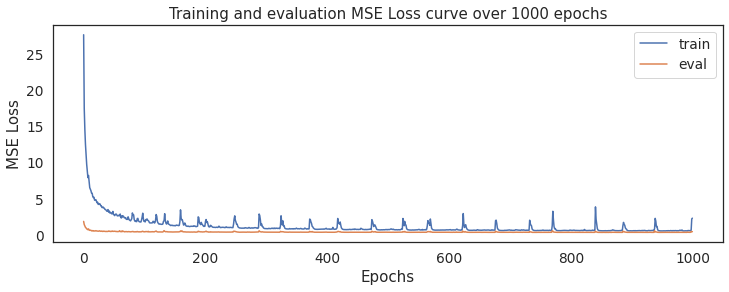

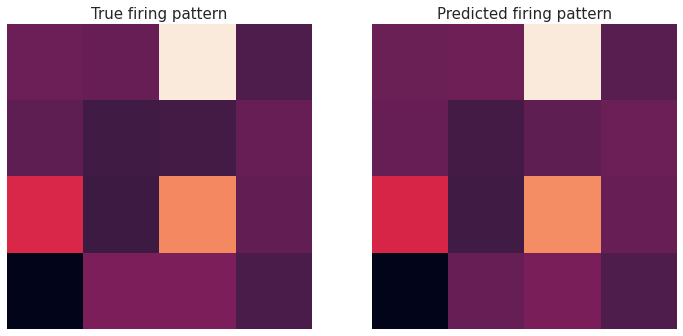

In [6]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss', fname='skip_mlp')

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:])) # visualise after training

#### 3. Testing against predicting the mean

In [ ]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

In [3]:
mses_skip = []
n_repeats = 20
for _ in range(n_repeats):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=False, force_stop=False)
    mses_skip.append(F.mse_loss(DNN(X_test), Y_test)) 
print(torch.mean(torch.Tensor(mses_skip)))
print(torch.std(torch.Tensor(mses_skip)))

tensor(0.0757)
tensor(0.0028)


### Recurrent BNN

In [7]:
X_train, Y_train = load_data('./data/', 'recurrent_train.pkl')
X_test, Y_test = load_data('./data/', 'recurrent_test.pkl')
X_valid, Y_valid = load_data('./data/', 'recurrent_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 1. Using MLP

##### a) Parameter search

In [9]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.5527623891830444, time elapsed: 0 h 1 m 3 s
2th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.5649966895580292, time elapsed: 0 h 2 m 14 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.5370296835899353, time elapsed: 0 h 3 m 37 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.5447198748588562, time elapsed: 0 h 4 m 57 s
5th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.5523774027824402, time elapsed: 0 h 6 m 12 s
6th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.5437135994434357, time elapsed: 0 h 7 m 33 s
7th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.543822467327118, time elapsed: 0 h 8 m 54 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.540532410144806, time elapsed: 0 h 10 m 14 s
9th repeat: best hidden unit: 256

Best hidden unit: 256, best layers: 2


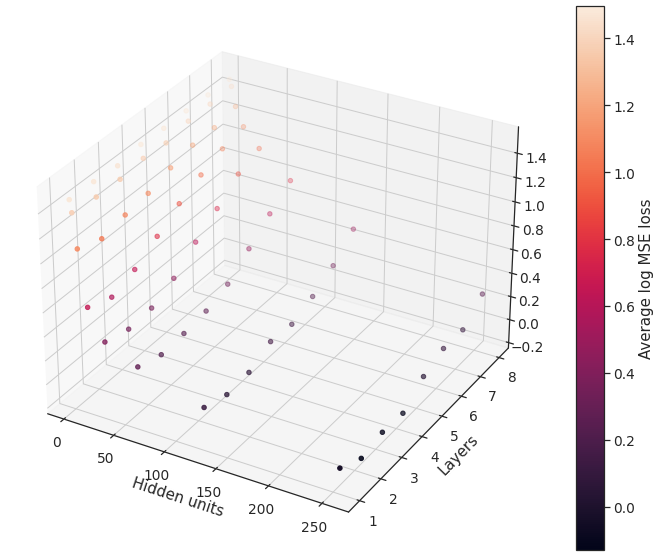

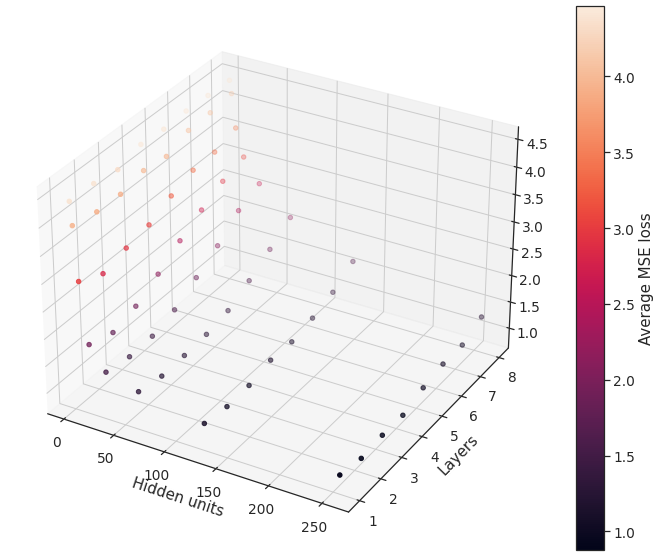

In [10]:
avg_final_eval_loss = torch.load('./temp/recurrent_mlp_param_search_2.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='recurrent_mlp_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='recurrent_mlp')
# torch.save(avg_final_eval_loss, './temp/recurrent_mlp_param_search_2.pt')

##### b) Learning with best parameter

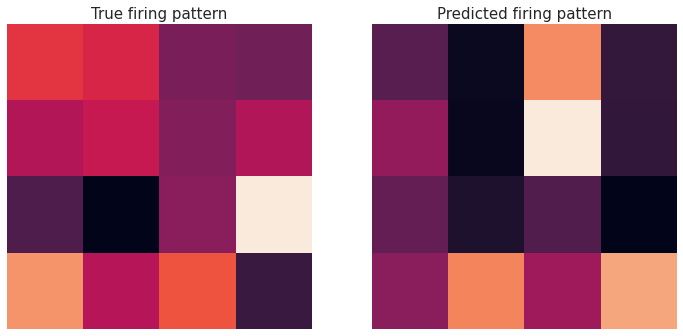

Initial eval loss: 5.015447020530701
Epoch 1: training loss 31.483563244342804, eval loss 2.3727256059646606. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 11.875745207071304, eval loss 1.2397943437099457. Time elapsed: 0 h 0 m 11 s.
Epoch 101: training loss 11.31561279296875, eval loss 1.234347939491272. Time elapsed: 0 h 0 m 21 s.
Epoch 151: training loss 10.933636888861656, eval loss 1.2468290776014328. Time elapsed: 0 h 0 m 32 s.
Epoch 201: training loss 10.75055681169033, eval loss 1.2806266397237778. Time elapsed: 0 h 0 m 43 s.
Epoch 251: training loss 10.344214662909508, eval loss 1.3257588744163513. Time elapsed: 0 h 0 m 54 s.
Epoch 301: training loss 9.655115514993668, eval loss 1.3618799448013306. Time elapsed: 0 h 1 m 6 s.
Epoch 351: training loss 10.027509704232216, eval loss 1.3824061155319214. Time elapsed: 0 h 1 m 17 s.
Epoch 401: training loss 10.281166657805443, eval loss 1.415877878665924. Time elapsed: 0 h 1 m 29 s.
Epoch 451: training loss 9.814496532082558, ev

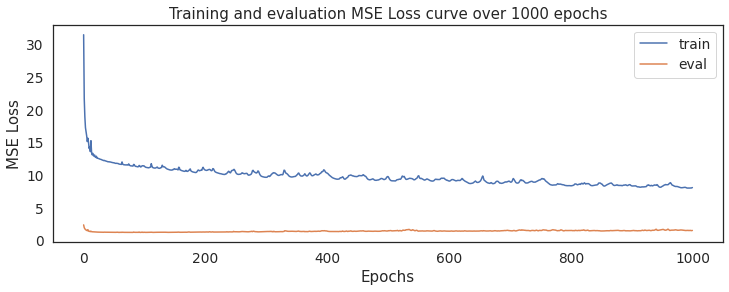

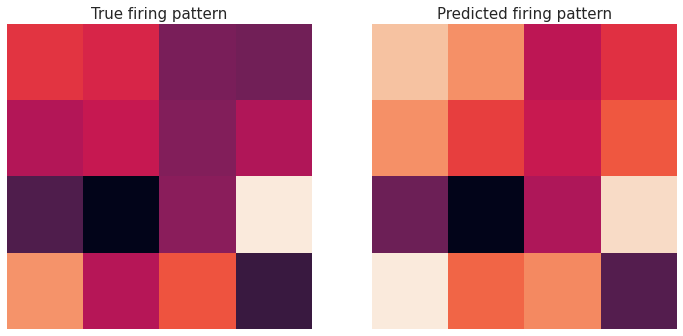

In [8]:
# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss',fname='fb_mlp')

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:])) # visualise after training

##### c) Testing against predicting the mean

In [7]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.2552, device='cuda:0')
Predicting mean MSE error on test set tensor(0.7593, device='cuda:0')


In [3]:
mses_rec_mlp = []
n_repeats = 20
for _ in range(n_repeats):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=2, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=False, force_stop=False)
    mses_rec_mlp.append(F.mse_loss(DNN(X_test), Y_test)) 
print(torch.mean(torch.Tensor(mses_rec_mlp)))
print(torch.std(torch.Tensor(mses_rec_mlp)))

tensor(0.2678)
tensor(0.0063)


#### 2. Using RNN

##### a) Parameter search

In [8]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 2.01944100856781, time elapsed: 0 h 1 m 15 s
2th repeat: best hidden unit: 256, best layers: 2, final eval loss: 2.0092600286006927, time elapsed: 0 h 2 m 40 s
3th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.9811238646507263, time elapsed: 0 h 4 m 0 s
4th repeat: best hidden unit: 256, best layers: 6, final eval loss: 2.0349889993667603, time elapsed: 0 h 5 m 24 s
5th repeat: best hidden unit: 256, best layers: 5, final eval loss: 2.0187368392944336, time elapsed: 0 h 6 m 48 s
6th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.9989043176174164, time elapsed: 0 h 8 m 10 s
7th repeat: best hidden unit: 256, best layers: 7, final eval loss: 2.0087122321128845, time elapsed: 0 h 9 m 33 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.975893497467041, time elapsed: 0 h 10 m 54 s
9th repeat: best hidden unit: 256,

Best hidden unit: 256, best layers: 3


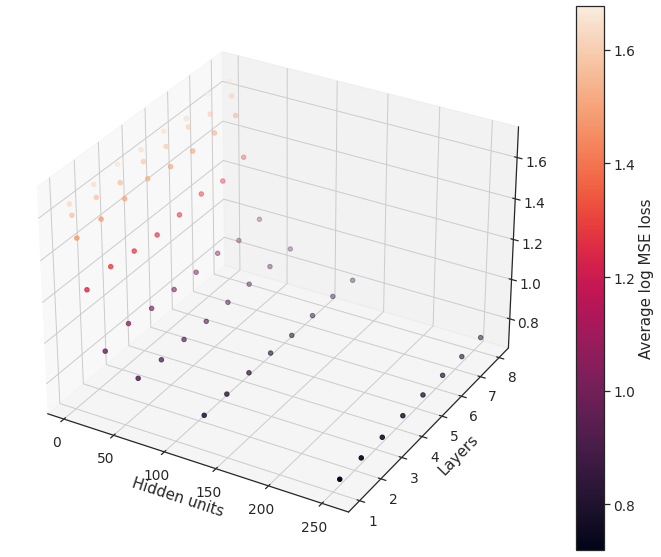

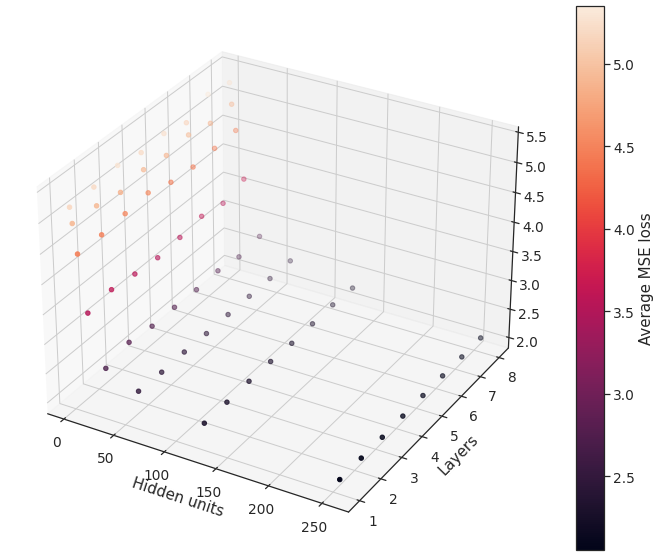

In [11]:
avg_final_eval_loss = torch.load('./temp/recurrent_lstm_param_search_2.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='recurrent_lstm_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='recurrent_lstm')
# torch.save(avg_final_eval_loss, './temp/recurrent_lstm_param_search_2.pt')

##### b) Learning with best parameter

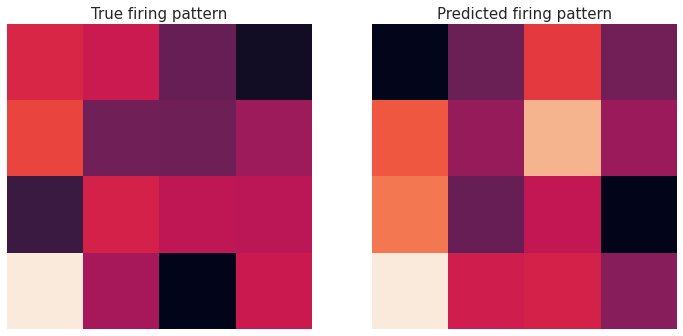

Initial eval loss: 11.59152626991272
Epoch 1: training loss 43.55406415462494, eval loss 2.695393145084381. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 14.09378457069397, eval loss 1.4040863811969757. Time elapsed: 0 h 0 m 11 s.
Epoch 101: training loss 13.686558037996292, eval loss 1.369560867547989. Time elapsed: 0 h 0 m 22 s.
Epoch 151: training loss 13.473427593708038, eval loss 1.348816305398941. Time elapsed: 0 h 0 m 33 s.
Epoch 201: training loss 13.34138399362564, eval loss 1.3354604840278625. Time elapsed: 0 h 0 m 44 s.
Epoch 251: training loss 13.269687861204147, eval loss 1.330497533082962. Time elapsed: 0 h 0 m 55 s.
Epoch 301: training loss 13.213709264993668, eval loss 1.3236587047576904. Time elapsed: 0 h 1 m 7 s.
Epoch 351: training loss 13.170224815607071, eval loss 1.3201920092105865. Time elapsed: 0 h 1 m 18 s.
Epoch 401: training loss 13.133204013109207, eval loss 1.3173121809959412. Time elapsed: 0 h 1 m 29 s.
Epoch 451: training loss 13.101568922400475, eva

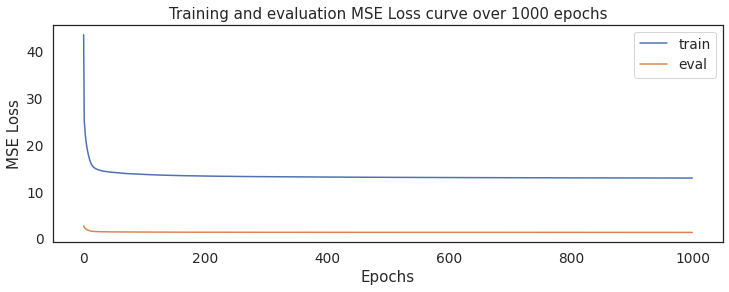

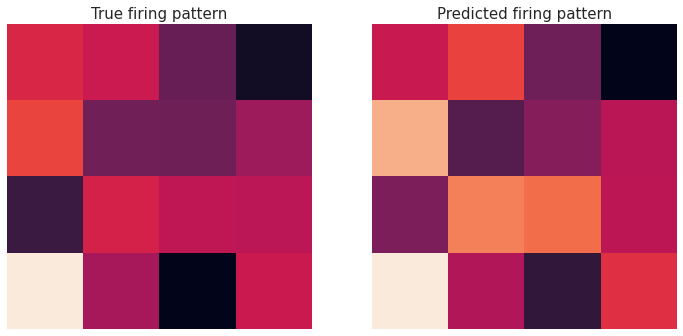

In [5]:
v_idx = 263
# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=3, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:])

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,0-1,:], Y_hats[v_idx,-1,:])

##### c) Testing against predicting the mean

In [6]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

DNN prediction MSE error on test set:  tensor(0.2591, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9991, device='cuda:0')


In [4]:
mses_rec_rnn = []
n_repeats = 20
for _ in range(n_repeats):
    DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=3, output_dim=16, n_lstm_layers=1).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses, eval_losses = train_rnn(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=True, force_stop=False)

    plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

    _, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
    mses_rec_rnn.append(F.mse_loss(DNN(X_test), Y_test)) 

print(torch.mean(torch.Tensor(mses_rec_rnn)))
print(torch.std(torch.Tensor(mses_rec_rnn)))

Initial eval loss: 13.744838953018188


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 7.80 GiB total capacity; 5.64 GiB already allocated; 30.56 MiB free; 5.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Complex BNN

#### USE MLP

In [ ]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

##### a) Parameter search

In [21]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})
torch.save(avg_final_eval_loss, './temp/complex_mlp_param_search_2.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.2724664062261581, time elapsed: 0 h 1 m 22 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.2968215644359589, time elapsed: 0 h 2 m 45 s
3th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.2963859587907791, time elapsed: 0 h 4 m 7 s
4th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.2958332002162933, time elapsed: 0 h 5 m 30 s
5th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.3324746191501617, time elapsed: 0 h 6 m 43 s
6th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.2603112906217575, time elapsed: 0 h 7 m 55 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.2861783653497696, time elapsed: 0 h 9 m 7 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.2602473944425583, time elapsed: 0 h 10 m 21 s
9th repeat: best hidden unit: 25

Best hidden unit: 256, best layers: 5


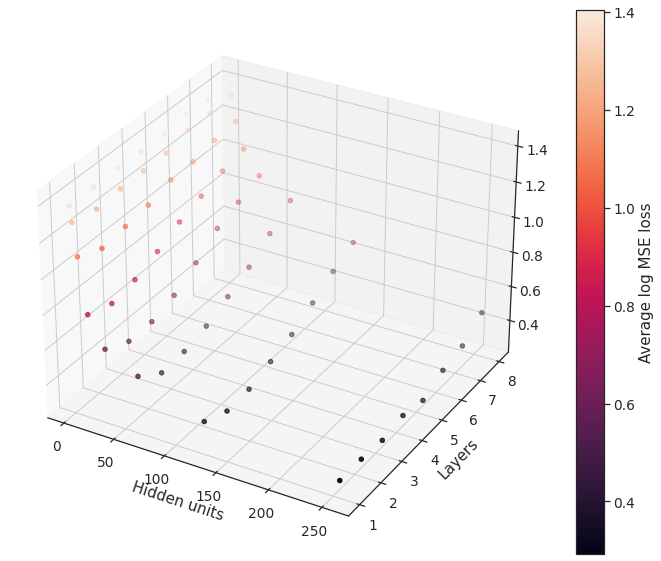

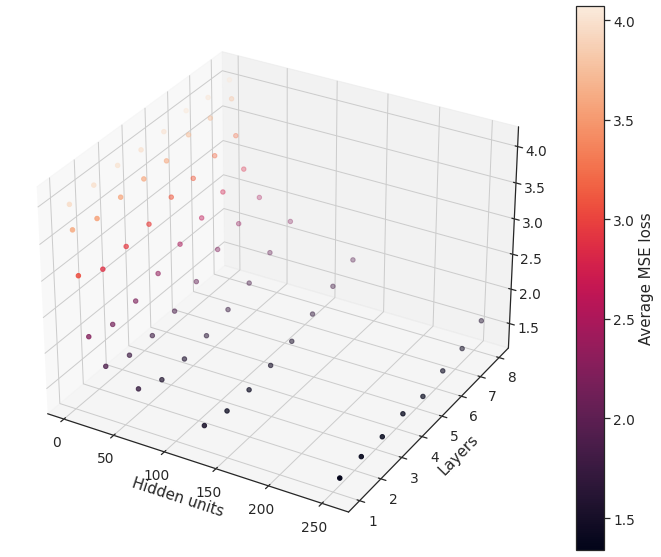

In [13]:
avg_final_eval_loss = torch.load('./temp/complex_mlp_param_search_2.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='complex_mlp_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='complex_mlp')

##### b) Learning with best parameter

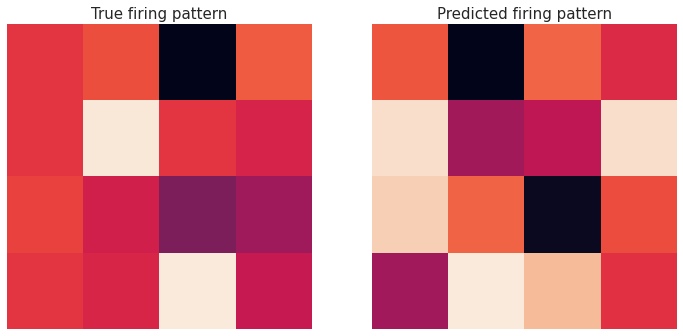

Initial eval loss: 3.8019070625305176
Epoch 1: training loss 28.572583943605423, eval loss 1.9883682131767273. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 11.695631623268127, eval loss 1.0507100820541382. Time elapsed: 0 h 0 m 13 s.
Epoch 101: training loss 11.150812178850174, eval loss 1.1165582984685898. Time elapsed: 0 h 0 m 26 s.
Epoch 151: training loss 9.212441697716713, eval loss 1.1260109841823578. Time elapsed: 0 h 0 m 39 s.
Epoch 201: training loss 9.049663081765175, eval loss 1.1895283609628677. Time elapsed: 0 h 0 m 52 s.
Epoch 251: training loss 8.05586153268814, eval loss 1.2393435835838318. Time elapsed: 0 h 1 m 6 s.
Epoch 301: training loss 7.851918250322342, eval loss 1.288483276963234. Time elapsed: 0 h 1 m 20 s.
Epoch 351: training loss 6.7393941804766655, eval loss 1.3072240948677063. Time elapsed: 0 h 1 m 33 s.
Epoch 401: training loss 6.198158010840416, eval loss 1.3371119499206543. Time elapsed: 0 h 1 m 47 s.
Epoch 451: training loss 5.984197176992893, eva

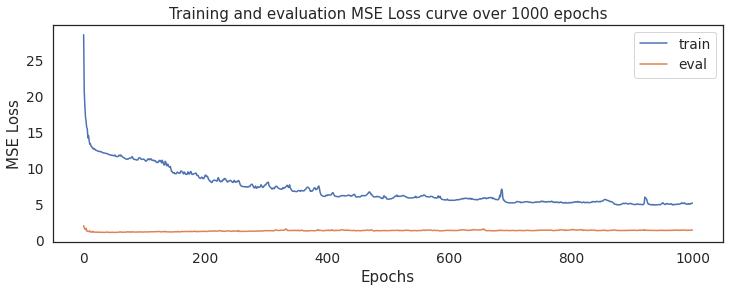

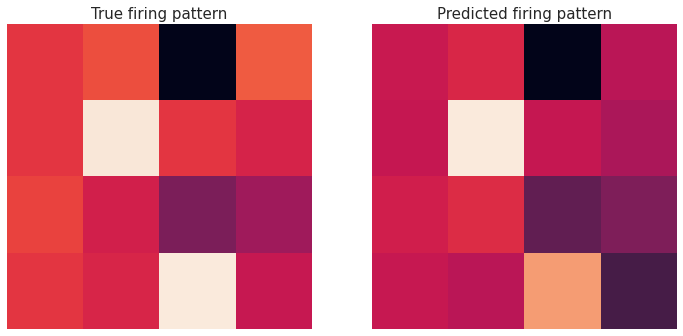

In [12]:
hidden_dim = 256
n_layers = 5

v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=hidden_dim, n_layers=n_layers, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,-1, :], DNN(X_test[v_idx,-1,:]))
torch.save(DNN.state_dict(), f'./dnn_params/complex_mlp_{n_layers}_{hidden_dim}.pt')

##### c) Testing against predicting the mean

In [13]:
print('DNN prediction MSE error on test set:', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

DNN prediction MSE error on test set: tensor(0.2740, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.7593, device='cuda:0')


In [ ]:
mses_cpx_mlp = []
n_repeats = 20
for _ in tqdm(range(n_repeats)):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=5, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=False, force_stop=False)
    mses_cpx_mlp.append(F.mse_loss(DNN(X_test), Y_test))
    
print(torch.mean(torch.Tensor(mses_cpx_mlp)))
print(torch.std(torch.Tensor(mses_cpx_mlp)))

In [14]:
# MSE by output neuron
DNN_params = torch.load(f'./dnn_params/complex_lstm_5_256.pt')
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=5, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

Y_hats, Y_test = Y_hats.view(-1, 16), Y_test.view(-1,16)
for neuron in range(16):
    print(f'Output neuron {neuron+1}: \n Entropy: {str(float(calc_entropy(Y_train[:,:,neuron])))[:5]}, MSE = {str(F.mse_loss(Y_hats[:,neuron], Y_test[:, neuron]).cpu().numpy())[:5]}')

Output neuron 1: 
 Entropy: 13.11, MSE = 0.677
Output neuron 2: 
 Entropy: 13.05, MSE = 4.140
Output neuron 3: 
 Entropy: 13.11, MSE = 1.891
Output neuron 4: 
 Entropy: 13.11, MSE = 1.647
Output neuron 5: 
 Entropy: 13.11, MSE = 0.288
Output neuron 6: 
 Entropy: 13.11, MSE = 2.802
Output neuron 7: 
 Entropy: 13.11, MSE = 0.527
Output neuron 8: 
 Entropy: 13.00, MSE = 1.342
Output neuron 9: 
 Entropy: 13.11, MSE = 10.91
Output neuron 10: 
 Entropy: 13.04, MSE = 1.377
Output neuron 11: 
 Entropy: 12.97, MSE = 5.127
Output neuron 12: 
 Entropy: 13.11, MSE = 1.680
Output neuron 13: 
 Entropy: 13.11, MSE = 4.685
Output neuron 14: 
 Entropy: 13.05, MSE = 3.129
Output neuron 15: 
 Entropy: 13.11, MSE = 1.289
Output neuron 16: 
 Entropy: 13.11, MSE = 3.628


#### USE RNN

##### a) Parameter search

In [8]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})
torch.save(avg_final_eval_loss, './temp/complex_lstm_param_search.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 8, final eval loss: 1.660589188337326, time elapsed: 0 h 1 m 7 s
2th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.6781300902366638, time elapsed: 0 h 2 m 24 s
3th repeat: best hidden unit: 256, best layers: 1, final eval loss: 1.654825896024704, time elapsed: 0 h 3 m 43 s
4th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.6988604664802551, time elapsed: 0 h 5 m 6 s
5th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.658075749874115, time elapsed: 0 h 6 m 32 s
6th repeat: best hidden unit: 256, best layers: 1, final eval loss: 1.66106316447258, time elapsed: 0 h 7 m 57 s
7th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.6640718281269073, time elapsed: 0 h 9 m 22 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.659622311592102, time elapsed: 0 h 10 m 46 s
9th repeat: best hidden unit: 256, bes

Best hidden unit: 256, best layers: 8


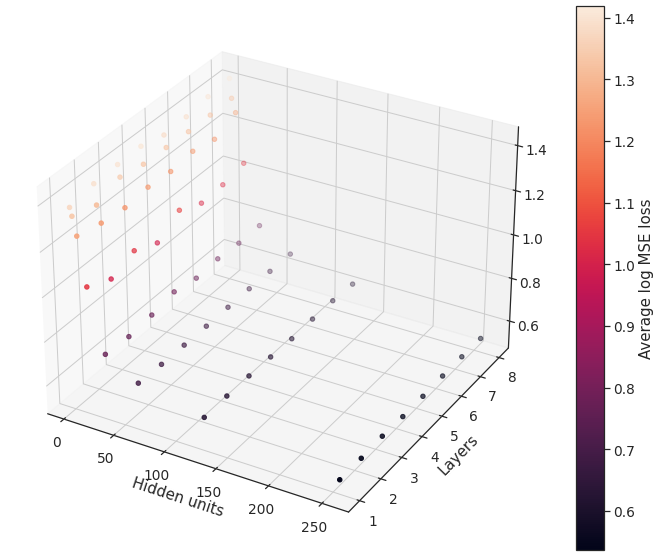

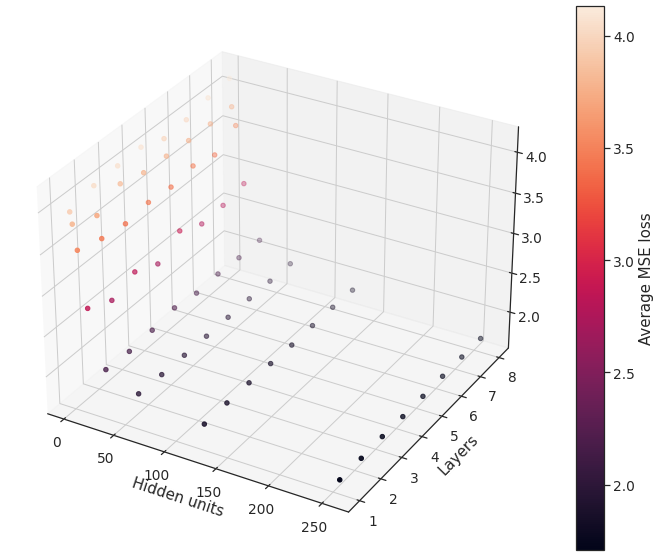

In [14]:
avg_final_eval_loss = torch.load('./temp/complex_lstm_param_search.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='complex_lstm_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='complex_lstm')

##### b) Learning with best parameter

In [4]:
hidden_dim = 256
n_linear_layers = 8

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=n_linear_layers, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:])

train_losses, eval_losses_10k = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:])

torch.save(DNN.state_dict(), f'./dnn_params/complex_lstm_{n_linear_layers}_{hidden_dim}.pt')

NameError: name 'v_idx' is not defined

##### c) Testing against predicting the mean

In [26]:
print('DNN prediction MSE error on test set:', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

DNN prediction MSE error on test set: tensor(0.2203, device='cuda:0')
Predicting mean MSE error on test set tensor(0.7593, device='cuda:0')


In [ ]:
mses_cpx_rnn = []
n_repeats = 20
for _ in range(n_repeats):
    DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=8, output_dim=16, n_lstm_layers=1).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses, eval_losses = train_rnn(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=True, force_stop=False)

    plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

    _, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
    mses_cpx_rnn.append(F.mse_loss(DNN(X_test), Y_test)) 

print(torch.mean(torch.Tensor(mses_cpx_rnn)))
print(torch.std(torch.Tensor(mses_cpx_rnn)))

Output neuron 1: 
 Entropy: 13.11, MSE = 0.000
Output neuron 2: 
 Entropy: 13.05, MSE = 0.683
Output neuron 3: 
 Entropy: 13.11, MSE = 0.130
Output neuron 4: 
 Entropy: 13.11, MSE = 0.096
Output neuron 5: 
 Entropy: 13.11, MSE = 0.020
Output neuron 6: 
 Entropy: 13.11, MSE = 0.140
Output neuron 7: 
 Entropy: 13.11, MSE = 0.077
Output neuron 8: 
 Entropy: 13.00, MSE = 0.651
Output neuron 9: 
 Entropy: 13.11, MSE = 0.134
Output neuron 10: 
 Entropy: 13.04, MSE = 0.118
Output neuron 11: 
 Entropy: 12.97, MSE = 0.193
Output neuron 12: 
 Entropy: 13.11, MSE = 0.258
Output neuron 13: 
 Entropy: 13.11, MSE = 0.060
Output neuron 14: 
 Entropy: 13.05, MSE = 0.555
Output neuron 15: 
 Entropy: 13.11, MSE = 0.228
Output neuron 16: 
 Entropy: 13.11, MSE = 0.162


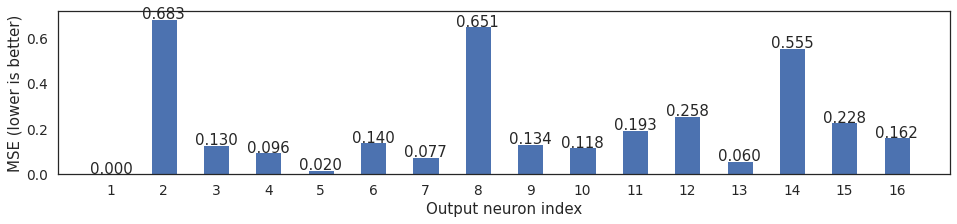

In [13]:
# MSE by output neuron
DNN_params = torch.load(f'./dnn_params/complex_lstm_5_256.pt')
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=5, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

Y_hats, Y_test = Y_hats.view(-1, 16), Y_test.view(-1,16)
MSEs = np.zeros(16)
for neuron in range(16):
    MSEs[neuron] = F.mse_loss(Y_hats[:,neuron], Y_test[:, neuron]).cpu().numpy()
    print(f'Output neuron {neuron+1}: \n Entropy: {str(float(calc_entropy(Y_train[:,:,neuron])))[:5]}, MSE = {str(MSEs[neuron])[:5]}')
plt.figure(figsize=(16,3))
w = 1
plt.bar(np.arange(16), MSEs, 0.5*w)
plt.xticks(np.arange(0, 16), np.arange(1,17))
plt.xlabel('Output neuron index')
plt.ylabel('MSE (lower is better)')
for i in range(16):
    plt.text(i, MSEs[i], str(MSEs[i])[:5], ha='center')


## Complexity of DNN vs Data Efficiency
What is the least complex DNN that does a good job of mimicking the approximate the complexBNN?

In [111]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

batch_size = 200                            # number of data points in each mini-batch
n_datas = [200, 400, 800, 1600, 3200, 6400, 10000]   # number of train data used, from 1 to len(X_train)
n_epochs = 50                               # number of training epochs

In [112]:
train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [4]:
avg_final_eval_losses = repeated_complexity_varying_data_efficiency(
    hidden_dims=hidden_dims, n_layerss=n_layerss, n_repeats=20, verbose=True,
    **{'input_dim':16,
       'output_dim':16,
       'train_dataset':train_dataset, 
       'test_dataloader':test_dataloader,
       'n_datas':n_datas,
       'n_epochs':n_epochs,
       'batch_size': batch_size,
       'type':'MLP'})
torch.save(avg_final_eval_losses, './temp/avg_final_eval_loss_f.pt')

1 of 20 repeats. Time elapsed: time elapsed: 0 h 20 m 1 soints.
2 of 20 repeats. Time elapsed: time elapsed: 0 h 40 m 14 sints.
3 of 20 repeats. Time elapsed: time elapsed: 1 h 0 m 35 soints.
4 of 20 repeats. Time elapsed: time elapsed: 1 h 20 m 49 sints.
5 of 20 repeats. Time elapsed: time elapsed: 1 h 41 m 3 soints.
6 of 20 repeats. Time elapsed: time elapsed: 2 h 1 m 30 soints.
7 of 20 repeats. Time elapsed: time elapsed: 2 h 21 m 46 sints.
8 of 20 repeats. Time elapsed: time elapsed: 2 h 42 m 1 soints.
9 of 20 repeats. Time elapsed: time elapsed: 3 h 2 m 21 soints.
10 of 20 repeats. Time elapsed: time elapsed: 3 h 22 m 50 snts.
11 of 20 repeats. Time elapsed: time elapsed: 3 h 43 m 0 sints.
12 of 20 repeats. Time elapsed: time elapsed: 4 h 3 m 15 sints.
13 of 20 repeats. Time elapsed: time elapsed: 4 h 23 m 33 snts.
14 of 20 repeats. Time elapsed: time elapsed: 4 h 43 m 54 snts.
15 of 20 repeats. Time elapsed: time elapsed: 5 h 4 m 2 soints.
16 of 20 repeats. Time elapsed: time ela

In [75]:
def plot_3d_scatter(x, y, z, x_label, y_label, z_label, colorbar=True, fname=False, title=False, figsize=(12,10)):
    '''
    Produces 3d scatter plot
    '''
    xyz = np.zeros([len(x)*len(y), 3])
    for i in range(len(x)):
        for j in range(len(y)):
            xyz[i*len(x)+j,:] = np.array([x[i], y[j], z[i,j]])
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt3d = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=xyz[:,2])
    ax.axes.set_zlim3d(bottom=0, top=6) 
    if title:
        plt.title(title)
    if colorbar:
        cbar = plt.colorbar(plt3d)
        cbar.set_label(z_label)
    if fname:
        plt.savefig('./figures/' + fname)
    plt.show()

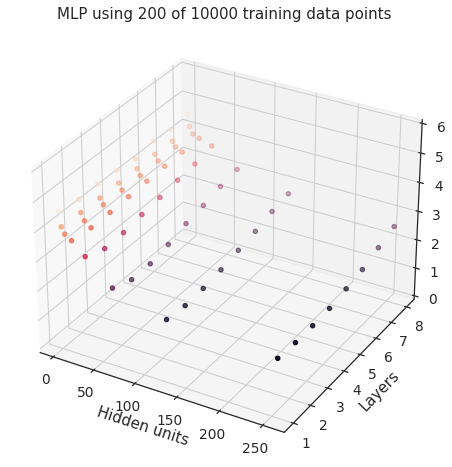

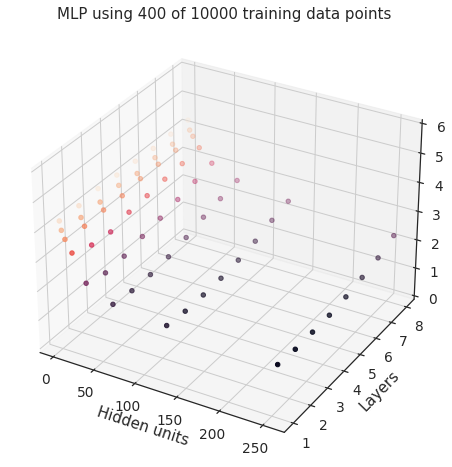

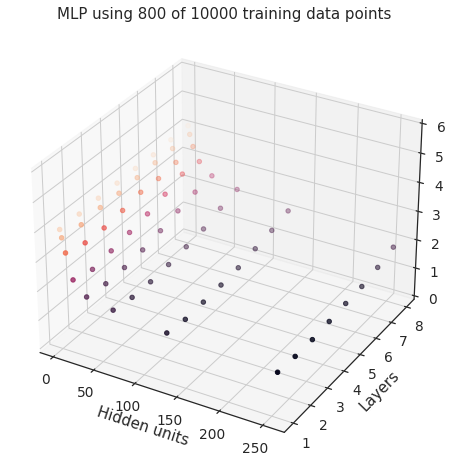

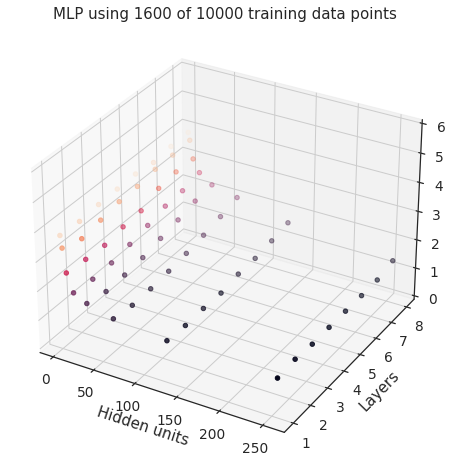

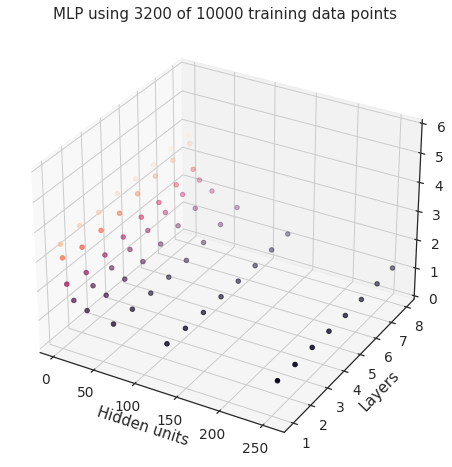

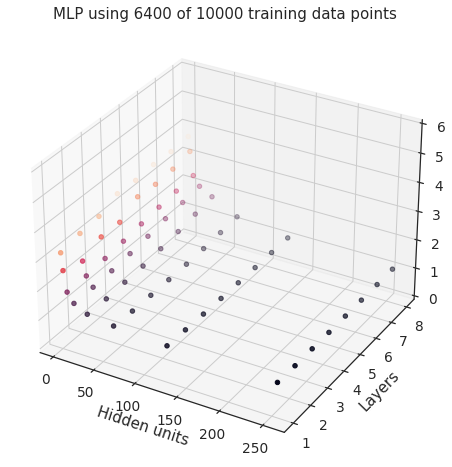

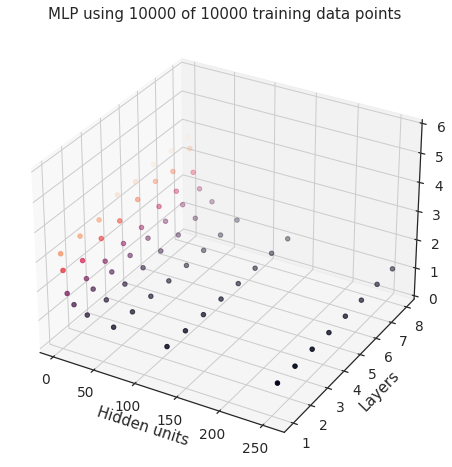

In [77]:
avg_final_eval_losses = torch.load('./temp/avg_final_eval_loss_f.pt')
for i, n_data in enumerate(n_datas):
    plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_losses[:,:,i],
                    x_label='Hidden units', y_label='Layers', z_label= f'Test set MSE loss for {n_data} training data', colorbar=False,
                    fname='data_efficiency', title=f'MLP using {n_data} of 10000 training data points', figsize=(10,8))

#### RNN

In [32]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

batch_size = 200                            # number of data points in each mini-batch
n_datas = [200, 400, 800, 1600, 3200, 6400, 10000]   # number of train data used, from 1 to len(X_train)
n_epochs = 50                               # number of training epochs

In [33]:
train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [34]:
avg_final_eval_losses = repeated_complexity_varying_data_efficiency(
    hidden_dims=hidden_dims, n_layerss=n_layerss, n_repeats=20, verbose=True,
    **{'input_dim':16,
       'output_dim':16,
       'train_dataset':train_dataset, 
       'test_dataloader':test_dataloader,
       'n_datas':n_datas,
       'n_epochs':n_epochs,
       'batch_size': batch_size,
       'type':'RNN'})
torch.save(avg_final_eval_losses, './temp/avg_final_eval_loss_rnn.pt')

1 of 20 repeats. Time elapsed: time elapsed: 0 h 20 m 32 sints.
2 of 20 repeats. Time elapsed: time elapsed: 0 h 41 m 1 soints.
3 of 20 repeats. Time elapsed: time elapsed: 1 h 1 m 39 soints.
4 of 20 repeats. Time elapsed: time elapsed: 1 h 22 m 5 soints.
5 of 20 repeats. Time elapsed: time elapsed: 1 h 42 m 45 sints.
6 of 20 repeats. Time elapsed: time elapsed: 2 h 3 m 21 soints.
7 of 20 repeats. Time elapsed: time elapsed: 2 h 23 m 58 sints.
8 of 20 repeats. Time elapsed: time elapsed: 2 h 44 m 29 sints.
9 of 20 repeats. Time elapsed: time elapsed: 3 h 5 m 4 spoints.
10 of 20 repeats. Time elapsed: time elapsed: 3 h 25 m 42 snts.
11 of 20 repeats. Time elapsed: time elapsed: 3 h 46 m 17 snts.
12 of 20 repeats. Time elapsed: time elapsed: 4 h 6 m 48 sints.
13 of 20 repeats. Time elapsed: time elapsed: 4 h 27 m 26 snts.
14 of 20 repeats. Time elapsed: time elapsed: 4 h 48 m 4 sints.
15 of 20 repeats. Time elapsed: time elapsed: 5 h 8 m 40 sints.
16 of 20 repeats. Time elapsed: time ela

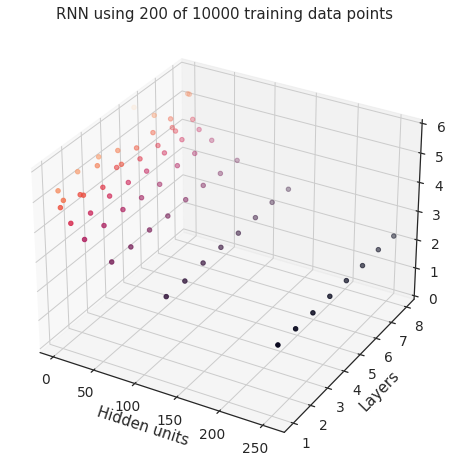

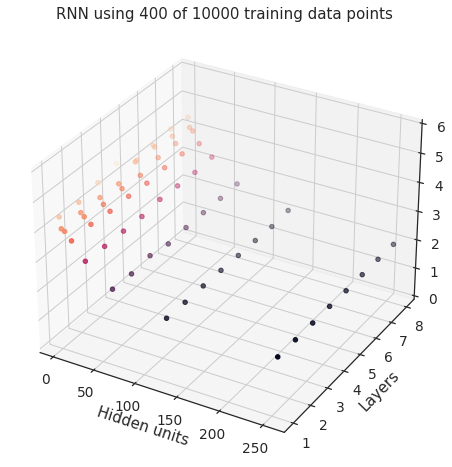

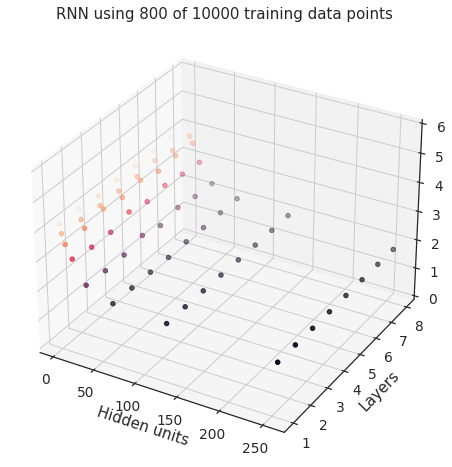

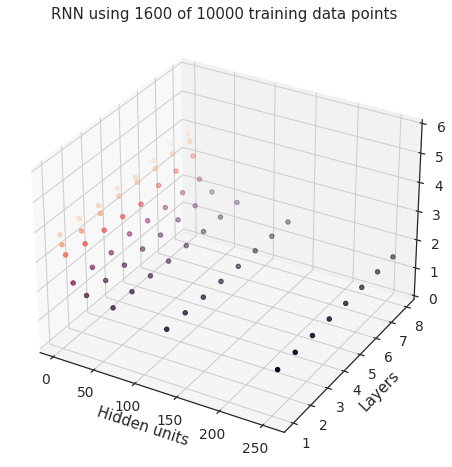

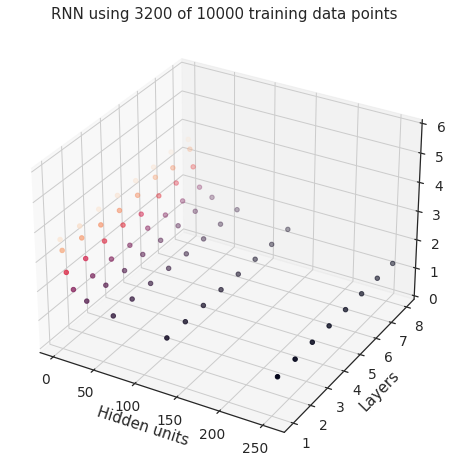

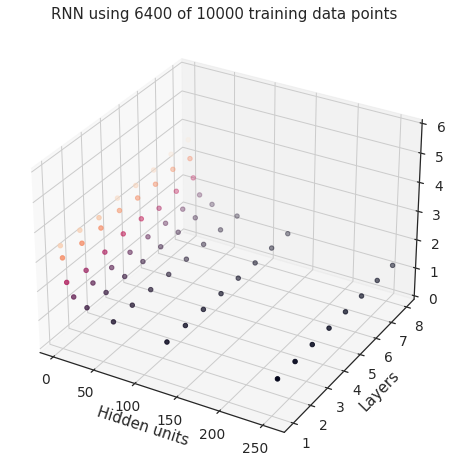

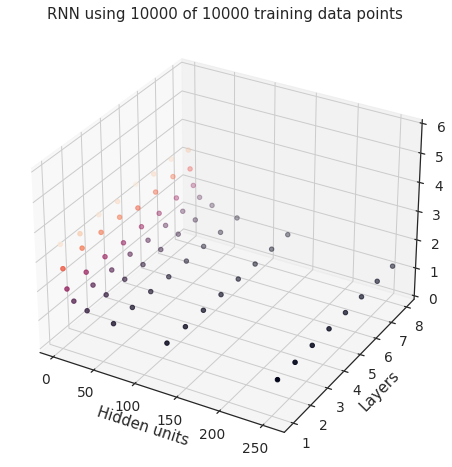

In [78]:
avg_final_eval_losses = torch.load('./temp/avg_final_eval_loss_rnn.pt')
for i, n_data in enumerate(n_datas):
    plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_losses[:,:,i],
                    x_label='Hidden units', y_label='Layers', z_label= f'Test set MSE loss for {n_data} training data', colorbar=False,
                    fname='data_efficiency', title=f'RNN using {n_data} of 10000 training data points', figsize=(10,8))

In [79]:
avg_final_eval_losses_rnn = torch.load('./temp/avg_final_eval_loss_rnn.pt')
avg_final_eval_losses_mlp = torch.load('./temp/avg_final_eval_loss_f.pt')

In [80]:
# avg_final_eval_losses_rnn[7,7,:]
avg_final_eval_losses_mlp[7,2,:]

tensor([1.8550, 1.6374, 1.3802, 1.2246, 1.1118, 1.0638, 1.0507])

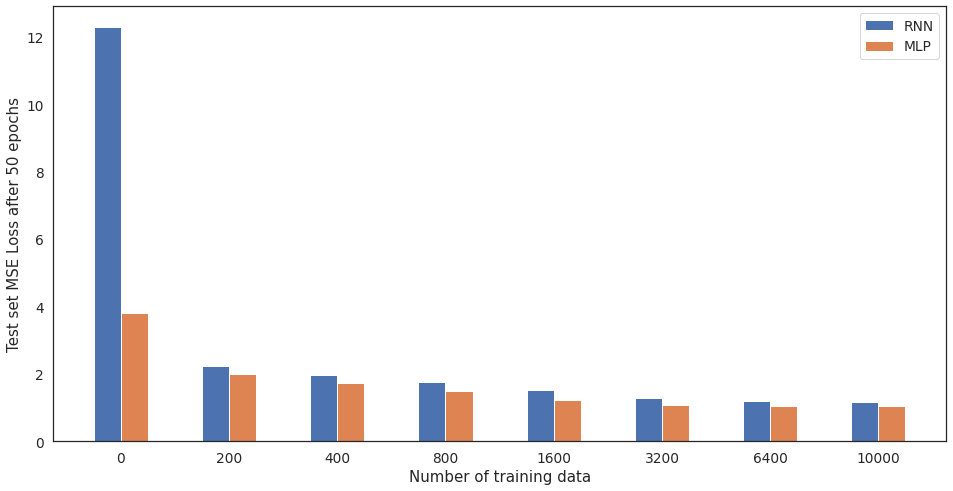

In [131]:
avg_final_eval_losses_rnn

n_datas = [0, 200, 400, 800, 1600, 3200, 6400, 10000]
# bar plot
width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(8) - width*1/4, torch.concat((torch.Tensor([mean_rnn]), avg_final_eval_losses_rnn[7,7,:])), width/2, label='RNN')
ax.bar(np.arange(8) + width*1/4, torch.concat((torch.Tensor([mean_mlp]), avg_final_eval_losses_mlp[7,4,:])), width/2, label='MLP')
plt.xlabel('Number of training data')
plt.ylabel('Test set MSE Loss after 50 epochs')
plt.legend()
plt.xticks(np.arange(len(n_datas)), n_datas)
plt.show()

In [124]:
mean_mlp = 0
mean_rnn = 0
for _ in range(30):
    DNN1 = FeedForwardDNN(16,256, 5, 16).to(device)
    DNN2 = RecurrentDNN(16, 256, 8, 16, 1).to(device)
    mean_mlp += eval(DNN1, test_dataloader, nn.MSELoss())
    mean_rnn += eval_rnn(DNN2, test_dataloader, nn.MSELoss())
mean_mlp /= 30
mean_rnn /= 30

In [128]:
torch.concat((torch.Tensor([mean_rnn]), avg_final_eval_losses_rnn[7,7,:]))
torch.concat((torch.Tensor([mean_mlp]), avg_final_eval_losses_mlp[7,7,:]))

tensor([3.8062, 2.5791, 2.2621, 1.8557, 1.3735, 1.1151, 1.0741, 1.0845])

In [139]:
avg_final_eval_losses_mlp[7,4,4] / avg_final_eval_losses_mlp[7,4,-1]

tensor(1.0233)

## BNN Plasticity analysis
We explore to what extent pre-training of a DNN helps when the plasticity of the approximate BNN is changed slightly (according to a Gaussian)

In [15]:
from approx_bnns import ComplexApproximateBNN

# BNN params
x, y, z = 256, 0.5, 4
bias = True
trainable = False
residual_in = [False, False, 1, 2]
num_epochs= 25

input_dim = 16
output_dim = 16
batch_size = 200
transfer_functions=[nn.ReLU(), nn.ELU(), nn.SiLU(), nn.CELU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(0.1), nn.LeakyReLU(0.2), nn.LeakyReLU(0.3)]

# initialise BNN, and load original weights
approx_bnn = ComplexApproximateBNN(
    x=x, y=y, z=z, 
    input_dim=input_dim, 
    output_dim=output_dim, 
    residual_in=residual_in, 
    recurrent_dim=-1, 
    transfer_functions=transfer_functions
).to(device)

BNN_weights = torch.load('./approx_bnn_params/complex.pt')
BNN_non_linearities = load_non_linearities('./approx_bnn_params/complex_activations.pkl')
approx_bnn.load_state_dict(BNN_weights)
approx_bnn.load_non_linearities(BNN_non_linearities)

# fixing input pattern
X_train, _ = load_data('./data/', 'complex_train.pkl')
X_test, _ = load_data('./data/', 'complex_test.pkl')
X_valid, _ = load_data('./data/', 'complex_valid.pkl')

In [16]:
# initialise DNN
hidden_dim = 256
n_layers = 8
DNN_params = torch.load(f'./dnn_params/complex_lstm_8_256.pt')
DNN = RecurrentDNN(input_dim=16, hidden_dim=hidden_dim, n_linear_layers=n_layers, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

<All keys matched successfully>

In [17]:
sigmas = torch.exp(torch.linspace(-7, 4, 12))
num_epochs = 30
params = {'DNN': DNN,
          'BNN': approx_bnn, 
          'DNN_params': DNN_params, 
          'BNN_params': (BNN_weights, BNN_non_linearities), 
          'sigmas': sigmas, 
          'batch_size': batch_size,
          'num_epochs': num_epochs,
          'X_train': X_train, 
          'X_test': X_test,
          'verbose': 2}

In [18]:
mean_transfer, std_transfer = repeated_plasticity_analysis(n_repeats=30, transfer_learning=True, **params)
mean_retrain, std_retrain = repeated_plasticity_analysis(n_repeats=30, transfer_learning=False, **params)

train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

Repeat 1/30
Processing sigma=0.0009118819725699723 (1/12)
	 Plasticity applied.
	 New output patterns generated.
Initial eval loss: 1.1354472637176514
Epoch 1: training loss 15.688322931528091, eval loss 1.130648359656334. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 14.472069799900055, eval loss 1.1279304176568985. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 14.459269598126411, eval loss 1.1281296163797379. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 14.457380518317223, eval loss 1.1281797140836716. Time elapsed: 0 h 0 m 1 s.
Epoch 5: training loss 14.459767743945122, eval loss 1.1275889575481415. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 14.460185214877129, eval loss 1.1273089498281479. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 14.45587308704853, eval loss 1.1280396431684494. Time elapsed: 0 h 0 m 2 s.
Epoch 8: training loss 14.456199541687965, eval loss 1.1277569979429245. Time elapsed: 0 h 0 m 2 s.
Epoch 9: training loss 14.459070280194283, eval los

In [19]:
torch.save((mean_transfer, std_transfer), './temp/RNN_plasticity_transfer.pt')
torch.save((mean_retrain, std_retrain), './temp/RNN_plasticity_retrain.pt')

In [14]:
(mean_transfer, std_transfer) = torch.load('./temp/RNN_plasticity_transfer_n.pt')
(mean_retrain, std_retrain) = torch.load('./temp/RNN_plasticity_retrain_n.pt')
train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

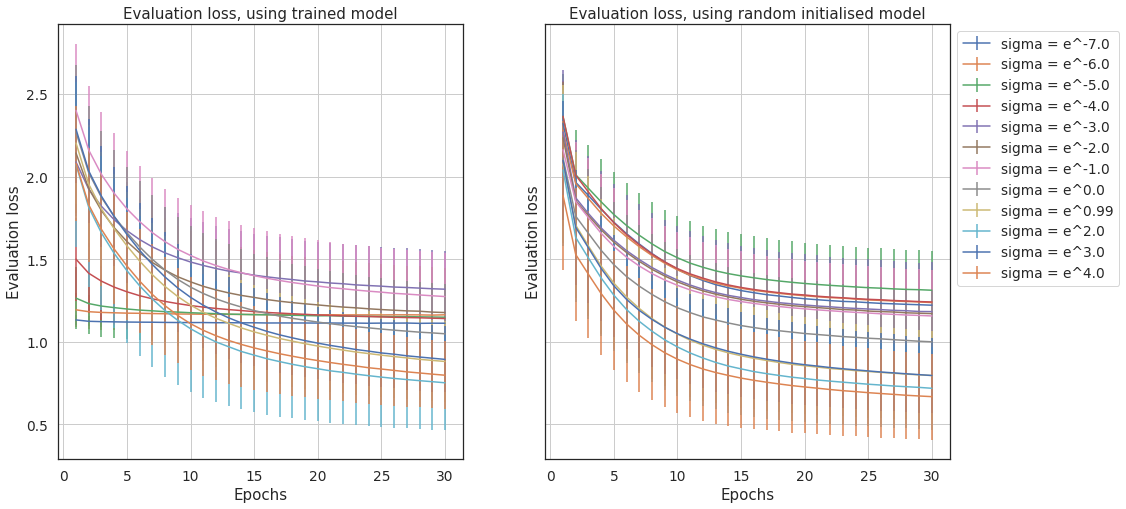

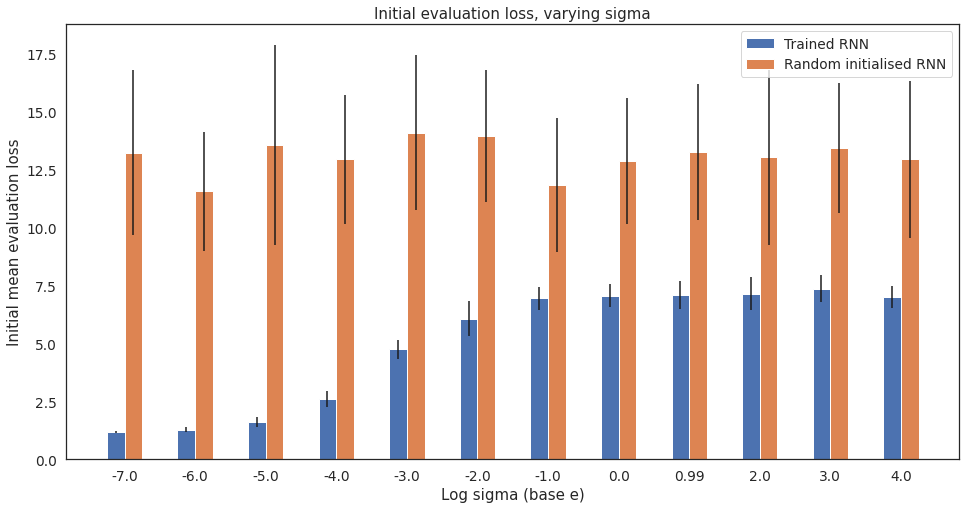

In [21]:
(mean_transfer, std_transfer) = torch.load( './temp/RNN_plasticity_transfer_n.pt')
(mean_retrain, std_retrain) = torch.load( './temp/RNN_plasticity_retrain_n.pt')


# normal scale loss
n_sigma = sigmas.shape[0]

f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,8))
plt.subplot(121)
plt.title('Evaluation loss, using trained model')
n_sigmas = len(sigmas)
for i in range(n_sigma): # for each sigma
    ax1.errorbar(np.arange(1, num_epochs+1), mean_transfer[1][i,:], yerr=std_transfer[1][i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.subplot(122)
plt.title('Evaluation loss, using random initialised model')
for i in range(train_losses_by_sigma_transfer.shape[0]):
    ax2.errorbar(np.arange(1, num_epochs+1), mean_retrain[1][i,:], yerr=std_retrain[1][i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.legend(bbox_to_anchor =(1, 1))

plt.savefig('./figures/plasticity_lstm.png')
plt.show()

width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(mean_transfer[2].shape[0]) - width/4, mean_transfer[2], width/2, yerr = std_transfer[2], label='Trained RNN')
ax.bar(np.arange(mean_retrain[2].shape[0]) + width/4, mean_retrain[2], width/2, yerr=std_retrain[2], label='Random initialised RNN')
plt.legend()
plt.xticks(np.arange(n_sigmas), [str(i.cpu().numpy())[:4] for i in torch.log(sigmas)])
plt.xlabel('Log sigma (base e)')
plt.ylabel('Initial mean evaluation loss')
plt.title('Initial evaluation loss, varying sigma')
plt.savefig('./figures/plasticity_2_lstm.png')
plt.show()

#### MLP

In [28]:
from approx_bnns import ComplexApproximateBNN

# BNN params
x, y, z = 256, 0.5, 4
bias = True
trainable = False
residual_in = [False, False, 1, 2]
num_epochs= 25

input_dim = 16
output_dim = 16
batch_size = 200
transfer_functions=[nn.ReLU(), nn.ELU(), nn.SiLU(), nn.CELU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(0.1), nn.LeakyReLU(0.2), nn.LeakyReLU(0.3)]

# initialise BNN, and load original weights
approx_bnn = ComplexApproximateBNN(
    x=x, y=y, z=z, 
    input_dim=input_dim, 
    output_dim=output_dim, 
    residual_in=residual_in, 
    recurrent_dim=-1, 
    transfer_functions=transfer_functions
).to(device)

BNN_weights = torch.load('./approx_bnn_params/complex.pt')
BNN_non_linearities = load_non_linearities('./approx_bnn_params/complex_activations.pkl')
approx_bnn.load_state_dict(BNN_weights)
approx_bnn.load_non_linearities(BNN_non_linearities)

# fixing input pattern
X_train, _ = load_data('./data/', 'complex_train.pkl')
X_test, _ = load_data('./data/', 'complex_test.pkl')
X_valid, _ = load_data('./data/', 'complex_valid.pkl')

# initialise DNN
hidden_dim = 256
n_layers = 5
DNN_params = torch.load(f'./dnn_params/complex_mlp_{n_layers}_{hidden_dim}.pt')
DNN = FeedForwardDNN(input_dim=16, hidden_dim=hidden_dim, n_layers=n_layers, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

<All keys matched successfully>

In [4]:
sigmas = torch.exp(torch.linspace(-7, 4, 12))
num_epochs = 30
params = {'DNN': DNN,
          'BNN': approx_bnn, 
          'DNN_params': DNN_params, 
          'BNN_params': (BNN_weights, BNN_non_linearities), 
          'sigmas': sigmas, 
          'batch_size': batch_size,
          'num_epochs': num_epochs,
          'X_train': X_train, 
          'X_test': X_test,
          'verbose': 0}

NameError: name 'DNN' is not defined

In [30]:
mean_transfer, std_transfer = repeated_plasticity_analysis(n_repeats=30, transfer_learning=True, **params)
mean_retrain, std_retrain = repeated_plasticity_analysis(n_repeats=30, transfer_learning=False, **params)

train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

torch.save((mean_transfer, std_transfer), './temp/MLP_plasticity_transfer_n.pt')
torch.save((mean_retrain, std_retrain), './temp/MLP_plasticity_retrain_n.pt')

Repeat 1/30
Repeat 2/30
Repeat 3/30
Repeat 4/30
Repeat 5/30
Repeat 6/30
Repeat 7/30
Repeat 8/30
Repeat 9/30
Repeat 10/30
Repeat 11/30
Repeat 12/30
Repeat 13/30
Repeat 14/30
Repeat 15/30
Repeat 16/30
Repeat 17/30
Repeat 18/30
Repeat 19/30
Repeat 20/30
Repeat 21/30
Repeat 22/30
Repeat 23/30
Repeat 24/30
Repeat 25/30
Repeat 26/30
Repeat 27/30
Repeat 28/30
Repeat 29/30
Repeat 30/30
Repeat 1/30
Repeat 2/30
Repeat 3/30
Repeat 4/30
Repeat 5/30
Repeat 6/30
Repeat 7/30
Repeat 8/30
Repeat 9/30
Repeat 10/30
Repeat 11/30
Repeat 12/30
Repeat 13/30
Repeat 14/30
Repeat 15/30
Repeat 16/30
Repeat 17/30
Repeat 18/30
Repeat 19/30
Repeat 20/30
Repeat 21/30
Repeat 22/30
Repeat 23/30
Repeat 24/30
Repeat 25/30
Repeat 26/30
Repeat 27/30
Repeat 28/30
Repeat 29/30
Repeat 30/30


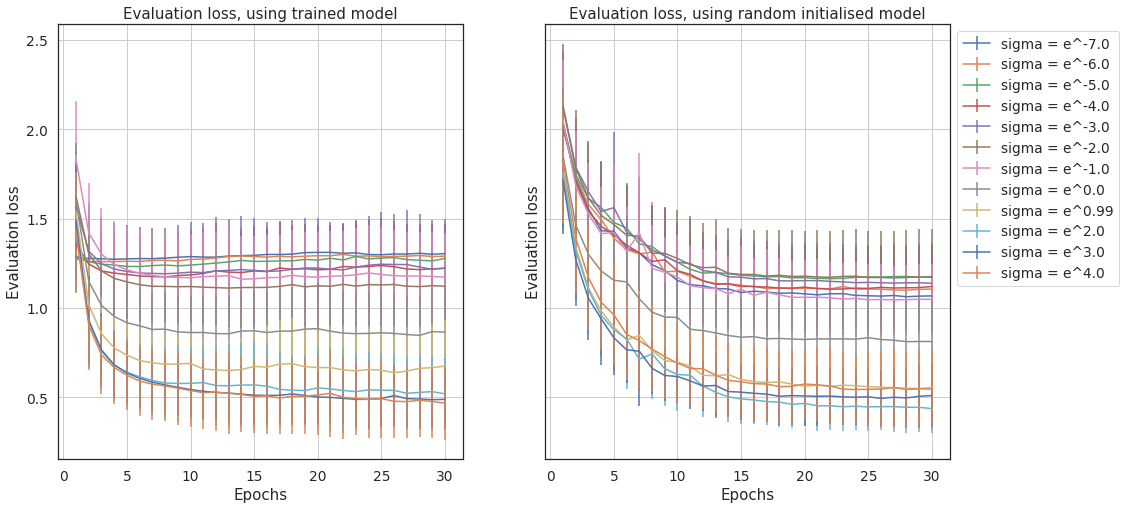

NameError: name 'std_transfer' is not defined

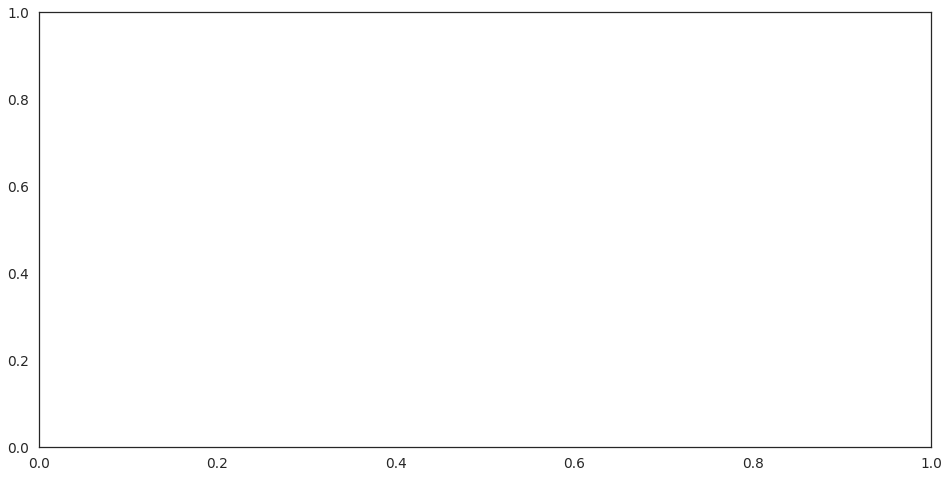

In [8]:
(mlp_mean_transfer, mlp_std_transfer) = torch.load( './temp/MLP_plasticity_transfer_n.pt')
(mlp_mean_retrain, mlp_std_retrain) = torch.load( './temp/MLP_plasticity_retrain_n.pt')
(rnn_mean_transfer, rnn_std_transfer) = torch.load( './temp/RNN_plasticity_transfer_n.pt')
(rnn_mean_retrain, rnn_std_retrain) = torch.load( './temp/RNN_plasticity_retrain_n.pt')

# normal scale loss
n_sigma = sigmas.shape[0]

f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,8))
plt.subplot(121)
plt.title('Evaluation loss, using trained model')
n_sigmas = len(sigmas)
for i in range(n_sigma): # for each sigma
    ax1.errorbar(np.arange(1, num_epochs+1), mlp_mean_transfer[1][i,:], yerr=mlp_std_transfer[1][i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.subplot(122)
plt.title('Evaluation loss, using random initialised model')
for i in range(mlp_mean_transfer[0].shape[0]):
    ax2.errorbar(np.arange(1, num_epochs+1), mlp_mean_retrain[1][i,:], yerr=mlp_std_retrain[1][i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.legend(bbox_to_anchor =(1, 1))

plt.savefig('./figures/plasticity_mlp.png')
plt.show()

width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(mlp_mean_transfer[2].shape[0]) - width*3/8, mlp_mean_transfer[2], width/4, yerr = std_transfer[2], label='Trained MLP')
ax.bar(np.arange(rnn_mean_transfer[2].shape[0]) - width*1/8, rnn_mean_transfer[2], width/4, yerr = std_transfer[2], label='Trained RNN')

ax.bar(np.arange(mlp_mean_retrain[2].shape[0]) + width*1/8, mlp_mean_retrain[2], width/4, yerr=std_retrain[2], label='Random initialised MLP')
ax.bar(np.arange(rnn_mean_retrain[2].shape[0]) + width*3/8, rnn_mean_retrain[2], width/4, yerr=std_retrain[2], label='Random initialised RNN')
plt.legend()
plt.xticks(np.arange(n_sigmas), [str(i.cpu().numpy())[:4] for i in torch.log(sigmas)])
plt.xlabel('Log sigma (base e)')
plt.ylabel('Initial mean evaluation loss')
plt.title('Initial evaluation loss, varying sigma')
plt.savefig('./figures/plasticity_2_mlp.png')
plt.show()

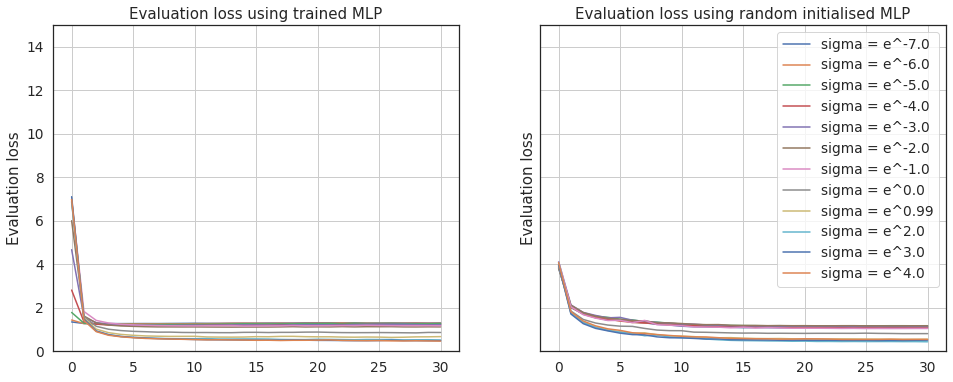

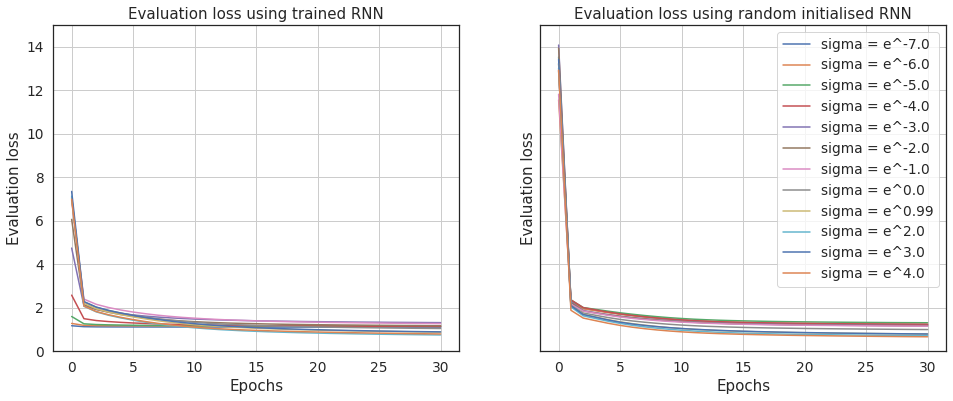

In [53]:
(mlp_mean_transfer, mlp_std_transfer) = torch.load( './temp/MLP_plasticity_transfer_n.pt')
(mlp_mean_retrain, mlp_std_retrain) = torch.load( './temp/MLP_plasticity_retrain_n.pt')
(rnn_mean_transfer, rnn_std_transfer) = torch.load( './temp/RNN_plasticity_transfer_n.pt')
(rnn_mean_retrain, rnn_std_retrain) = torch.load( './temp/RNN_plasticity_retrain_n.pt')


# stack initial loss
mlp_transfer_mean, mlp_transfer_std = torch.vstack((mlp_mean_transfer[2], mlp_mean_transfer[1].T)).T, torch.vstack((mlp_std_transfer[2], mlp_std_transfer[1].T)).T
mlp_retrain_mean, mlp_retrain_std = torch.vstack((mlp_mean_retrain[2], mlp_mean_retrain[1].T)).T, torch.vstack((mlp_std_retrain[2], mlp_std_retrain[1].T)).T

rnn_transfer_mean, rnn_transfer_std = torch.vstack((rnn_mean_transfer[2], rnn_mean_transfer[1].T)).T, torch.vstack((rnn_std_transfer[2], rnn_std_transfer[1].T)).T
rnn_retrain_mean, rnn_retrain_std = torch.vstack((rnn_mean_retrain[2], rnn_mean_retrain[1].T)).T, torch.vstack((rnn_std_retrain[2], rnn_std_retrain[1].T)).T



n_sigmas = len(sigmas)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
plt.subplot(121)
plt.title('Evaluation loss using trained MLP')

for i in range(n_sigma): # for each sigma
    ax1.errorbar(np.arange(0, num_epochs+1), mlp_transfer_mean[i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.ylabel('Evaluation loss')


plt.subplot(122)
plt.title('Evaluation loss using random initialised MLP')
for i in range(n_sigma):
    ax2.errorbar(np.arange(0, num_epochs+1), mlp_retrain_mean[i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.ylabel('Evaluation loss')

plt.ylim([0,15])
plt.legend(bbox_to_anchor =(1, 1))
plt.show()



f, (ax3, ax4) = plt.subplots(1,2, sharey=True, figsize=(16,6))

plt.subplot(121)
plt.title('Evaluation loss using trained RNN')

for i in range(n_sigma): # for each sigma
    ax3.errorbar(np.arange(0, num_epochs+1), rnn_transfer_mean[i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')


plt.subplot(122)
plt.title('Evaluation loss using random initialised RNN')
for i in range(n_sigma):
    ax4.errorbar(np.arange(0, num_epochs+1), rnn_retrain_mean[i,:], label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')
plt.ylim([0,15])
plt.legend(bbox_to_anchor =(1, 1))

plt.show()

In [37]:
mlp_transfer_mean.shape

torch.Size([12, 31])

###### 